In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.optimize as sop
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')


In [45]:
mosprime3m = pd.read_csv('mosprime3m.csv',header=None,
                         index_col=0, names=['r3m'])['r3m'].sort_index()

mosprime3m_short = pd.read_csv('mosprime3m_short.csv', header=None,
                               index_col=0, names=['r3m'])['r3m'].sort_index()

mosprime3m_between = pd.read_csv('mosprime3m_between.csv', header=None,
                                 index_col=0, names=['r3m'])['r3m'].sort_index()

In [45]:
from scipy.special import

In [33]:
def CIR_path(r0, days, theta, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    a = a # альфа 
    theta = theta
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = r[t - 1] +  a * (theta - r[t-1]) * dt + vol * rand[t] * np.sqrt(dt * r[t - 1])
    CIR = pd.DataFrame(r[:, 0], columns=['index'])
    CIR = CIR.values.flatten()
    return CIR


def CIR_p(data, opt, num_paths=10, alpha=0.7, title='Calibrated CIR Short Rate Simulation'):
    for i in range(num_paths):
        plt.plot(CIR_path(data[0], len(data), opt[0], opt[1],
                      opt[2]), lw=0.8, alpha=alpha)
    plt.title(title)
    plt.plot(data.values.flatten(), label = 'data')
    plt.legend()
    plt.tight_layout
    plt.show()
    
#def CIR_ml_final_diff(p0, penalty=np.inf):
#    theta, a, vol = p0
#    if theta <= 0 or vol <= 0 or a <= 0 :
#        return penalty 
#    x = data.values
#    dx = np.diff(data.values)
#    dt = np.array([1/252]*len(dx))
#    dt = np.array([1]*len(dx))
    
#    c = 2 * a / (1 - np.exp( - a * dt)) / vol**2
#    q = 2 * theta * a / vol - 1
#    u =  c * x[:-1] * np.exp( - a * dt)
#    v =  c * x[1:]
    
#    f = np.zeros(len(dx))
#    for i in range(len(dx)):
#        f[i] = np.log(c[i]) + ( - u[i] - v[i]) + q * np.log(v[i]/ u[i]) + np.log( iv(q, 2 * np.sqrt(u[i] * v[i])))
        #print(c[0], u[i], v[i], q, np.log(c[i]), ( - u[i] - v[i]), q * np.log(v[i]/ u[i]), 2 * np.sqrt(u[i] * v[i]), iv(q, 2 * np.sqrt(u[i] * v[i])))
#    L = - np.sum(f)
#    if L == -np.inf:
#        return penalty
    #print(L)
#    return L


def CIR_ml_final_diff(p0, penalty=np.inf):
    theta, a, vol = p0
    if theta <= 0 or vol <= 0 or a <= 0 :
        return penalty 
    x = data
    dx = np.diff(data)
    dt = np.array([1/252]*len(dx))
    #dt = np.array([1]*len(dx))
    
    mu = a * (theta - x[:-1]) * dt 
    sigma = vol * np.sqrt(dt * x[:-1])
    
    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [4]:
def mean_max_dist(opt, data, num_paths):
    dist = []
    for i in range(num_paths):
        pathes =  CIR_path(data[0], len(data), opt[0], opt[1], opt[2])
        dist.append(np.max(np.abs(pathes - data)))
    return np.mean(dist)

In [51]:
data = mosprime3m_short

In [52]:
p1 = np.array([0.01, 0.01, 0.01])
p2 = np.array([0.1,  0.1, 0.1])
p3 = np.array([np.median(data),  max(data) - min(data) , np.sqrt(data.var())])
p4 = np.array([40, 2, 1])

Optimization terminated successfully.
         Current function value: -205.918481
         Iterations: 108
         Function evaluations: 187
[ 7.2423527   5.41769214  0.1997239 ]
0.369270777769


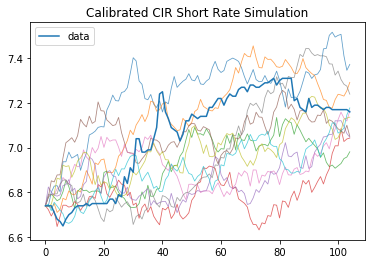

In [53]:
CIR_ml_ex1 = sop.fmin(CIR_ml_final_diff, p3,
               maxiter=10000, maxfun=10000, xtol=0.001, ftol=0.001)

print(CIR_ml_ex1)
print(mean_max_dist(CIR_ml_ex1, data, num_paths=10))
CIR_p(data, CIR_ml_ex1, num_paths=10)

In [54]:
sop.minimize(CIR_ml_final_diff, p3, method='Powell')

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -6.75129708e-01,   3.91445295e-01,  -1.53583689e-04]])
     fun: -205.3669897869861
 message: 'Optimization terminated successfully.'
    nfev: 161
     nit: 4
  status: 0
 success: True
       x: array([ 7.72804313,  1.39013794,  0.20077929])

In [90]:
data = mosprime3m

In [91]:
def rolling_CIR(db=mosprime3m, periods=21):
    date_start_end = (pd.date_range(end = db.index.min(), periods=1, freq='d') + periods - 1).strftime('%Y-%m-%d')[0]
    #end_dates = pd.date_range(start=date_start_end, end = db.index.max(), freq='d').strftime('%Y-%m-%d')
    #end_dates = [i for i in end_dates if i in db.index]
    df_cal_CIR = pd.DataFrame(columns=["theta", "alpha", "vol", "mean", "median", "std"], index=np.array(db.index[periods:]))
    for i in tqdm(range(len(df_cal_CIR))):
        global data
        data = db.dropna().values[i:(periods+i)]
        x = data
        median = np.median(x)
        mean = np.mean(x)
        std = np.std(x)
        p4 = [median, np.max(x)-np.min(x), std]#db252_HW1.values[i,:3]
        par = sop.minimize(CIR_ml_final_diff, p4, method='Powell').x
        #par = sop.fmin(CIR_ml_final_diff, p3, disp=0,
        #      maxiter=10000, maxfun=10000, xtol=0.001, ftol=0.001)
        df_cal_CIR.iloc[i] = np.append(par, [mean, median, std])
    return df_cal_CIR

In [92]:
db252_CIR = rolling_CIR(periods=252)

100%|██████████| 2469/2469 [00:34<00:00, 71.79it/s]


In [93]:
db252_CIR.head()

,theta,alpha,vol,mean,median,std
2008-01-10,7.29322,0.547006,0.459645,5.86115,5.53,0.943377
2008-01-11,6.35236,0.795909,0.48886,5.86258,5.53,0.943268
2008-01-14,6.36211,0.843483,0.487527,5.86377,5.53,0.9431
2008-01-15,6.3132,0.827002,0.487121,5.86544,5.53,0.942756
2008-01-16,6.08975,0.855387,0.491698,5.86627,5.53,0.942534


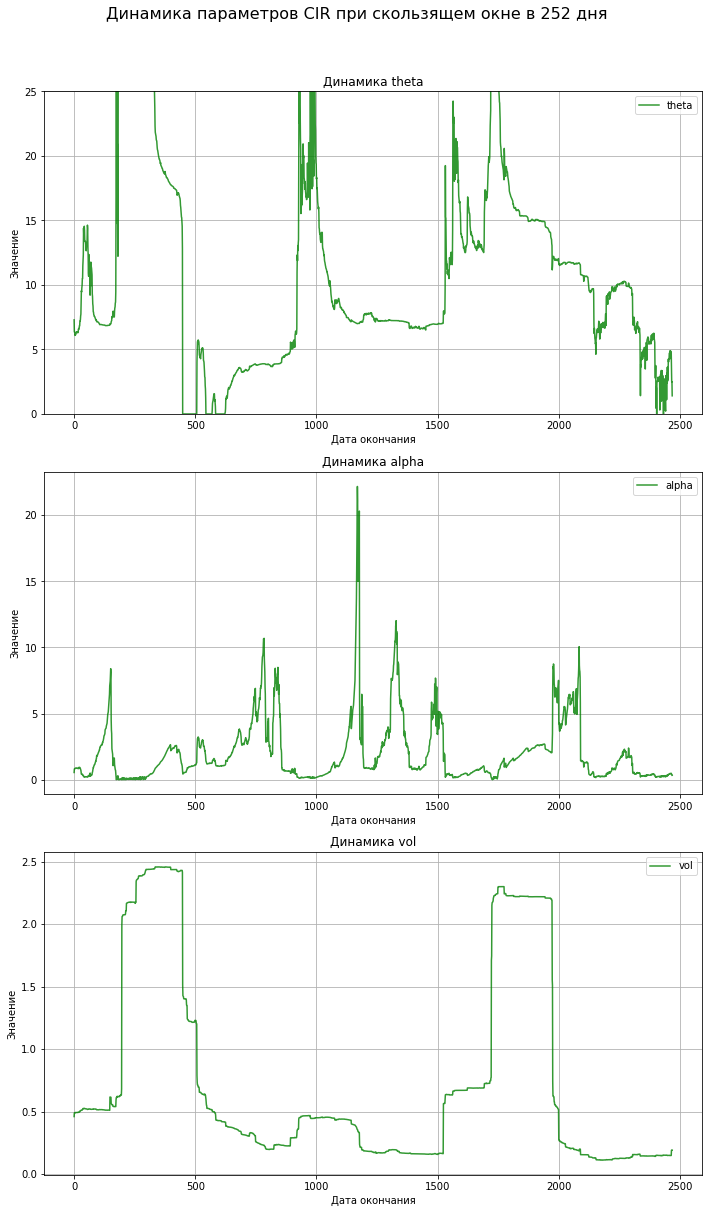

In [94]:
plt.figure(figsize=[10,16])
plt.subplot(3,1,1)
plt.plot(db252_CIR['theta'].values , 'g-',  alpha = 0.8, label = 'theta')
plt.title('Динамика theta')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.ylim([0,25])
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(db252_CIR['alpha'].values , 'g-',  alpha = 0.8, label = 'alpha')
plt.title('Динамика alpha')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot(db252_CIR['vol'].values , 'g-',  alpha = 0.8, label = 'vol')
plt.title('Динамика vol')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()


plt.suptitle('Динамика параметров CIR при скользящем окне в 252 дня' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

In [95]:
a = np.array(db252_CIR['alpha'].values, dtype=float)
l = np.array(db252_CIR['theta'].values, dtype=float)
vol = np.array(db252_CIR['vol'].values, dtype=float)

In [96]:
x = mosprime3m.values[:-252]

t252 = np.array([252/252]*len(a))
sigma252 = np.sqrt(x * vol**2/a * (np.exp(- a * t252) - np.exp(- 2 * a * t252)) + l * vol**2/(2 * a) * (1 - np.exp(- a * t252))**2)
mu252 = x * np.exp(-a * t252) + l * (1 - np.exp(-a * t252))

t1 = np.array([1/252]*len(a))
sigma1 = np.sqrt(x * vol**2/a * (np.exp(- a * t1) - np.exp(- 2 * a * t1)) + l * vol**2/(2 * a) * (1 - np.exp(- a * t1))**2)
mu1 = x * np.exp(-a * t1) + l * (1 - np.exp(-a * t1))

t21 = np.array([21/252]*len(a))
sigma21 = np.sqrt(x * vol**2/a * (np.exp(- a * t21) - np.exp(- 2 * a * t21)) + l * vol**2/(2 * a) * (1 - np.exp(- a * t21))**2)
mu21 = x * np.exp(-a * t21) + l * (1 - np.exp(-a * t21))

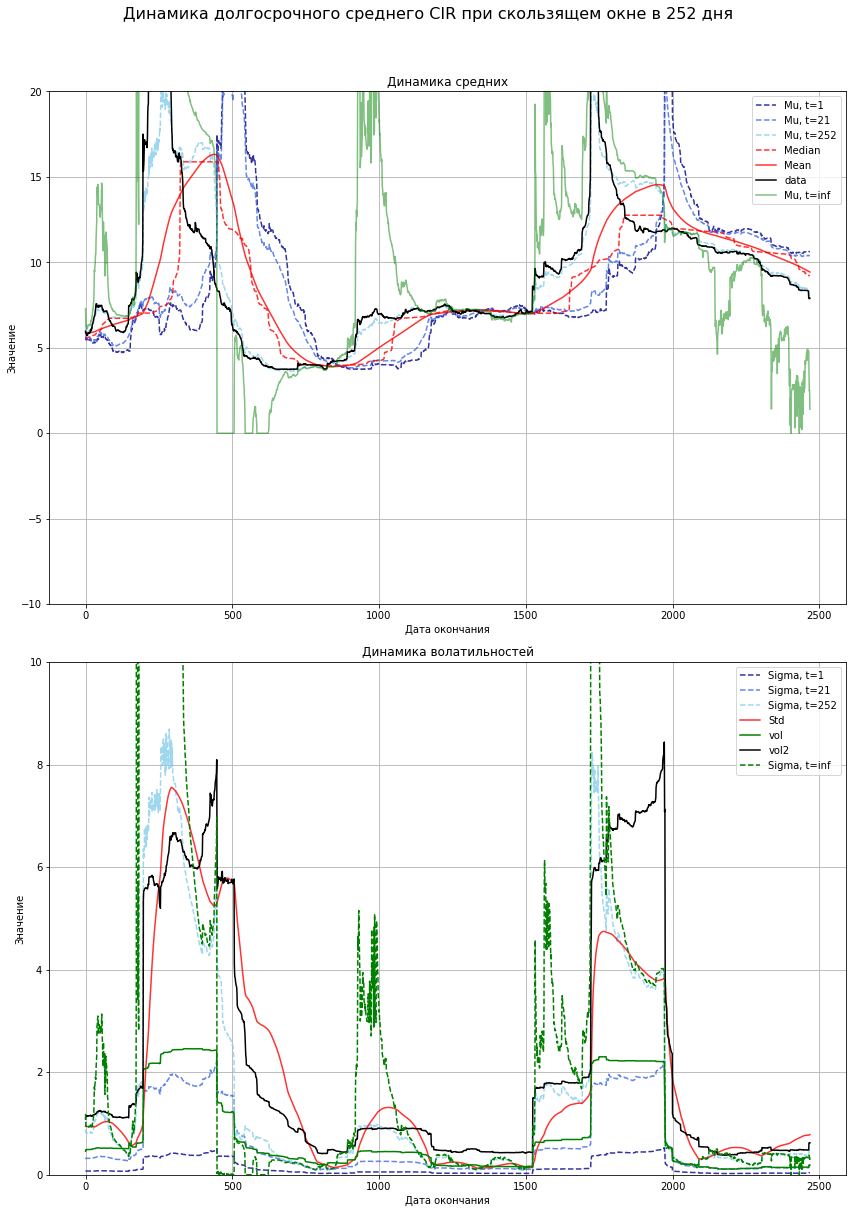

In [97]:
plt.figure(figsize=[12,16])

plt.subplot(2,1,1)
plt.plot(mu1 , '--', color='darkblue',  alpha = 0.8, label = 'Mu, t=1')
plt.plot(mu21 , '--', color='royalblue',  alpha = 0.8, label = 'Mu, t=21')
plt.plot(mu252 , '--', color='skyblue',  alpha = 0.8, label = 'Mu, t=252')
plt.plot(db252_CIR['median'].values , 'r--',  alpha = 0.8, label = 'Median')
plt.plot(db252_CIR['mean'].values , 'r-',  alpha = 0.8, label = 'Mean')
plt.plot(mosprime3m.values[252:] , 'black', label = 'data')
plt.plot(l , 'g-',  alpha = 0.5, label = 'Mu, t=inf')
plt.title('Динамика средних')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.ylim([-10,20])
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(sigma1 , '--', color='darkblue',  alpha = 0.8, label = 'Sigma, t=1')
plt.plot(sigma21 , '--', color='royalblue',  alpha = 0.8, label = 'Sigma, t=21')
plt.plot(sigma252 ,'--', color='skyblue',  alpha = 0.8, label = 'Sigma, t=252')
plt.plot(db252_CIR['std'].values , 'r-',  alpha = 0.8, label = 'Std')
plt.plot(db252_CIR['vol'].values , 'g-',  alpha = 1, label = 'vol')
plt.plot(np.sqrt(x) * db252_CIR['vol'].values , 'k-',  alpha = 1, label = 'vol2')
plt.plot( np.sqrt(l * vol**2/(2 * a)) , 'g--',  alpha = 1, label = 'Sigma, t=inf')

plt.title('Динамика волатильностей')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.ylim([0,10])
plt.legend()
plt.grid()

plt.suptitle('Динамика долгосрочного среднего CIR при скользящем окне в 252 дня' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

In [65]:
def mean_max_dist(opt, data, num_paths):
    dist = []
    for i in range(num_paths):
        dist.append(np.max(np.abs(data - CIR_path(data[0], len(data), opt[0], opt[1], opt[2]))))
    return np.mean(dist)

def opt_mean_max_dist(p0):
    return mean_max_dist(p0, data, num_paths=100)

[ 7.3155034   0.93623937  0.21377875]
0.889964335345


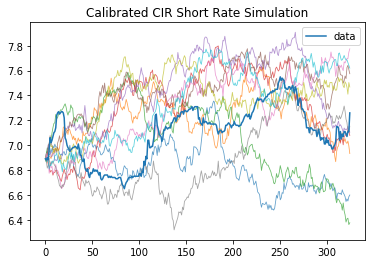

In [377]:
CIR_dist_ex1 = sop.fmin(opt_mean_max_dist, p3,
               maxiter=100, maxfun=100, xtol=0.01, ftol=0.01)

print(CIR_dist_ex1)
print(mean_max_dist(CIR_dist_ex1, data, num_paths=10))
CIR_p(data, CIR_dist_ex1, num_paths=10)

In [378]:
def mean_sum_dist(opt, data, num_paths):
    dist = []
    for i in range(num_paths):
        dist.append(np.sum(np.abs(data - CIR_path(data[0], len(data), opt[0], opt[1], opt[2]))))
    return np.max(dist)

def opt_mean_sum_dist(p0):
    return mean_sum_dist(p0, data, num_paths=10)

[ 7.48058401  0.87356171  0.2263283 ]
190.643058139


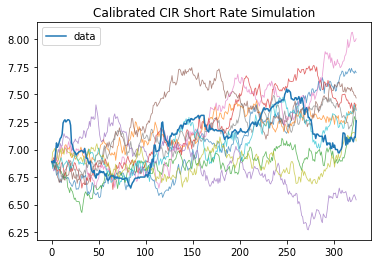

In [394]:
CIR_dist_sum_ex1 = sop.fmin(opt_mean_sum_dist, p3,
               maxiter=100, maxfun=100, xtol=0.1, ftol=0.1)

print(CIR_dist_sum_ex1)
print(mean_sum_dist(CIR_dist_sum_ex1, data, num_paths=10))
CIR_p(data, CIR_dist_sum_ex1, num_paths=10)

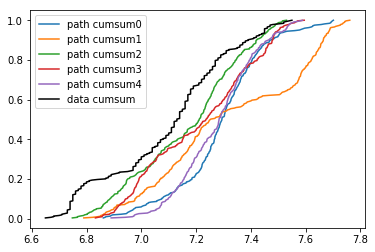

In [408]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

xs, ys = ecdf(data)
for i in range(5):
    xs1, ys1 = ecdf(CIR_path(data[0], len(data), CIR_ml_ex1[0], CIR_ml_ex1[1], CIR_ml_ex1[2]))
    plt.plot(xs1, ys1, label="path cumsum" + str(i))
plt.plot(xs, ys, 'k',label="data cumsum")
plt.legend()
plt.show()

In [402]:
def f_mean_max_dist(opt, data, num_paths):
    dist = []
    for i in range(num_paths):
        dist.append(np.max(np.abs(ecdf(data)[0] - ecdf(CIR_path(data[0], len(data), opt[0], opt[1], opt[2]))[0])))
    return np.mean(dist)

def f_opt_mean_sum_dist(p0):
    return f_mean_max_dist(p0, data, num_paths=10)

[ 7.48652772  0.89999614  0.22232172]
0.843423853657
0.403703159028


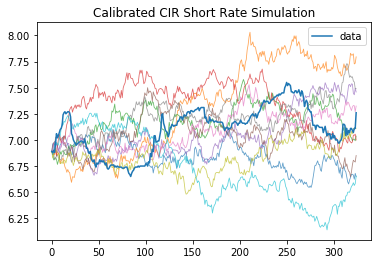

In [406]:
CIR_dist_f = sop.fmin(f_opt_mean_sum_dist, p3,
               maxiter=10000, maxfun=10000, xtol=0.1, ftol=0.01)

print(CIR_dist_f)
print(mean_max_dist(CIR_dist_sum_ex1, data, num_paths=10))
print(f_mean_max_dist(CIR_dist_sum_ex1, data, num_paths=10))
CIR_p(data, CIR_dist_f, num_paths=10)

In [455]:
xs1, ys1 = ecdf(CIR_path(data[0], len(data), CIR_ml_ex1[0], CIR_ml_ex1[1], CIR_ml_ex1[2]))
xs, ys = ecdf(data)

In [456]:
minv = np.minimum(xs1[0], xs[0]) - 0.001
maxv = np.maximum(xs1[-1], xs[-1]) + 0.001

xs = np.insert(xs, 0, minv)
xs1 =  np.insert(xs1, len(xs1), minv)
xs1 = np.insert(xs1, -0, maxv)
xs = np.insert(xs, len(xs), maxv)

ys = np.insert(ys, 0, 0)
ys = np.insert(ys, len(ys), 1)
ys1 = np.insert(ys1, 0, 0)
ys1 = np.insert(ys1, len(ys), 1)

In [ ]:
f = np.zeros(len(xs))
for i in range(len(xs)):
    if xs[0] == xs1[0]:
        f[0] = np.abs(ys[0]-ys[0])
    else:

In [ ]:
if xs[0] == xs1[0]:
    f[0] = ys[0]-ys[0]
else:
    

In [440]:
dx = (np.abs(ys1 - ys[40])).min()
dx

0.0

In [457]:
xs

array([ 6.649,  6.65 ,  6.67 ,  6.68 ,  6.68 ,  6.7  ,  6.71 ,  6.71 ,
        6.72 ,  6.73 ,  6.73 ,  6.73 ,  6.73 ,  6.73 ,  6.73 ,  6.74 ,
        6.74 ,  6.74 ,  6.74 ,  6.74 ,  6.74 ,  6.74 ,  6.74 ,  6.74 ,
        6.74 ,  6.74 ,  6.74 ,  6.74 ,  6.74 ,  6.75 ,  6.75 ,  6.75 ,
        6.75 ,  6.75 ,  6.75 ,  6.75 ,  6.75 ,  6.75 ,  6.75 ,  6.75 ,
        6.76 ,  6.76 ,  6.76 ,  6.76 ,  6.76 ,  6.76 ,  6.77 ,  6.77 ,
        6.77 ,  6.78 ,  6.78 ,  6.78 ,  6.78 ,  6.78 ,  6.79 ,  6.79 ,
        6.79 ,  6.79 ,  6.8  ,  6.8  ,  6.8  ,  6.81 ,  6.81 ,  6.82 ,
        6.84 ,  6.87 ,  6.87 ,  6.88 ,  6.88 ,  6.88 ,  6.89 ,  6.89 ,
        6.89 ,  6.9  ,  6.91 ,  6.92 ,  6.92 ,  6.95 ,  6.96 ,  6.97 ,
        6.97 ,  6.97 ,  6.97 ,  6.97 ,  6.97 ,  6.97 ,  6.98 ,  6.98 ,
        6.98 ,  6.98 ,  6.98 ,  6.98 ,  6.99 ,  6.99 ,  6.99 ,  6.99 ,
        6.99 ,  7.   ,  7.   ,  7.   ,  7.   ,  7.   ,  7.01 ,  7.01 ,
        7.01 ,  7.02 ,  7.02 ,  7.03 ,  7.03 ,  7.04 ,  7.04 ,  7.04 ,
      